In [1]:
import os
import sys
sys.path.append('..')
sys.path.append('../../ur5_mujoco/')

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from sdf_module import SDFModule

ModuleNotFoundError: No module named 'real_sdf_module'

In [9]:
sdf_module = SDFModule(rgb_feature=True, resnet_feature=True, convex_hull=False, binary_hole=True, using_depth=False, tracker='medianflow', resize=True)

NameError: name 'SDFModule' is not defined

In [5]:
urenv = UR5Env(render=False, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', gpu=0, camera_depth=True, dataset="train1", small=False)
env = objectwise_env(urenv, num_blocks=3, mov_dist=0.08, detection=True)

Creating window glfw


In [7]:
env.depth_bg

array([[0.47922167, 0.47922167, 0.47922167, ..., 0.47922167, 0.47922167,
        0.47922167],
       [0.4785942 , 0.4785942 , 0.4785942 , ..., 0.4785942 , 0.4785942 ,
        0.4785942 ],
       [0.47796974, 0.47796974, 0.47796974, ..., 0.47796974, 0.47796974,
        0.47796974],
       ...,
       [0.29487306, 0.29487306, 0.29487306, ..., 0.29487306, 0.29487306,
        0.29487306],
       [0.29463536, 0.29463536, 0.29463536, ..., 0.29463536, 0.29463536,
        0.29463536],
       [0.29439807, 0.29439807, 0.29439807, ..., 0.29439807, 0.29439807,
        0.29439807]], dtype=float32)

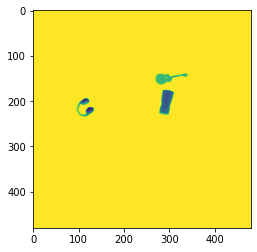

In [10]:
plt.imshow(state_img[1] - env.depth_bg)

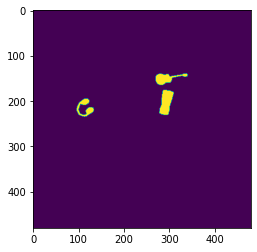

In [11]:
d = state_img[1] - env.depth_bg
plt.imshow(d.astype(bool))

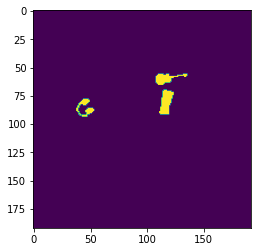

In [19]:
plt.imshow(cv2.resize(d.astype(bool).astype(np.uint8), (192, 192)))

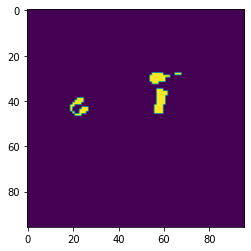

In [18]:
plt.imshow(cv2.resize(d.astype(bool).astype(np.uint8), (96, 96)))

In [20]:
import skfmm
def get_sdf(mask):
    return skfmm.distance(mask.astype(int) - 0.5, dx=1)

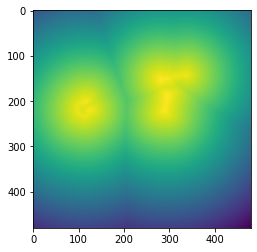

In [22]:
plt.imshow(get_sdf(d.astype(bool)))

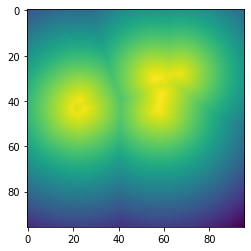

In [33]:
sdf1 = cv2.resize(get_sdf(d.astype(bool)), (96, 96))/5
plt.imshow(sdf1)

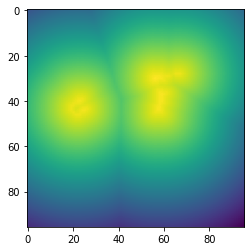

In [34]:
sdf2 = get_sdf(cv2.resize(d.astype(bool).astype(float), (96, 96)))
plt.imshow(sdf2)

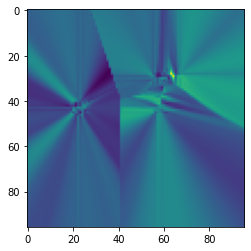

In [35]:
plt.imshow(sdf1 - sdf2)

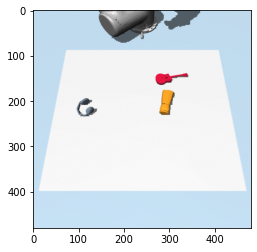

In [8]:
(state_img, goal_img), info = env.reset()
plt.imshow(state_img[0])

In [16]:
masks, feature = sdf_module.get_ucn_masks(state_img[0], None, 'HWC')

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [19]:
len(masks)

5

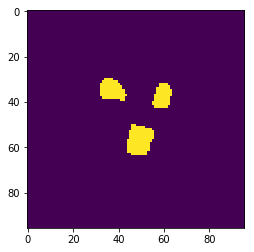

In [29]:
plt.imshow(np.sum(masks[:3], 0))

In [33]:
s = sdf_module.get_sdf([np.sum(masks[:3], 0)])

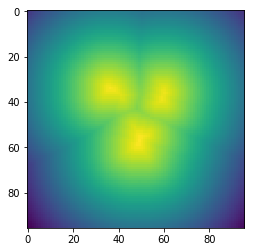

In [35]:
plt.imshow(s[0])

In [36]:
from mpl_toolkits.mplot3d import Axes3D

In [37]:
x, y = np.meshgrid(range(96), range(96)[::-1])

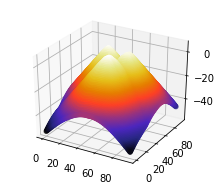

In [42]:
fig = plt.figure(figsize=(12, 3))
ax0 = fig.add_subplot(131, projection="3d")
# ax1 = fig.add_subplot(132, projection="3d")
# ax2 = fig.add_subplot(133, projection="3d")
ax0.scatter(x, y, s[0].reshape(-1), c=s[0].reshape(-1), cmap='CMRmap')
# ax1.scatter(x, y, sdf_others, c=sdf_others, cmap='CMRmap')
# ax2.scatter(x, y, final, c=final, cmap='CMRmap')

In [ ]:
import sys
sys.path.append('..')

In [1]:
from models.sdf_gat import *

In [2]:
qnet = SDFGATQNet(3, sdim=1, fdim=12, hdim=64).to(device)

In [3]:
nb = 3
bs = 7
ch = 1
h, w = 96, 96
f = 12

sdf_st = torch.rand([bs, nb, ch, h, w]).to(device)
sdf_g = torch.rand([bs, nb, ch, h, w]).to(device)
feature_st = torch.rand([bs, nb, f]).to(device)
feature_g = torch.rand([bs, nb, f]).to(device)
obs_st = [sdf_st, feature_st]
obs_g = [sdf_g, feature_g]

nb_st = torch.randint(0, nb+1, (bs, 1)).to(device)
nb_g = torch.randint(0, nb+1, (bs, 1)).to(device)

In [4]:
atn_in, atn_g = qnet(obs_st, obs_g, nb_st, nb_g)

In [1]:
import sys
sys.path.append('..')
sys.path.append('../../ur5_mujoco')

#from ur5_env import *
from realobjects_env import *
from object_env import *

from sdf_module import *

In [2]:
sdf = SDFModule(rgb_feature=True, convex_hull=False, binary_hole=True, using_depth=False, tracker='kcf')

env = UR5Env(render=True, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', camera_depth=True)
env = objectwise_env(env, num_blocks=3, mov_dist=0.08, detection=True)

/home/gun/Desktop/ur5_manipulation/object_wise/../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


Creating window glfw


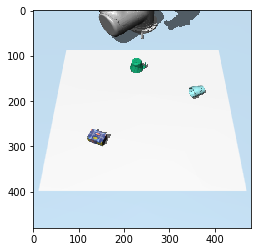

In [52]:
(state_img, goal_img), info = env.reset()
plt.imshow(state_img[0])

In [53]:
masks, feature = sdf.get_ucn_masks(state_img[0], None, 'HWC')

In [54]:
sdfs = sdf.get_sdf(masks)

In [8]:
from mpl_toolkits.mplot3d import Axes3D

In [9]:
x, y = np.meshgrid(range(96), range(96)[::-1])

In [ ]:
len(sdfs)

5

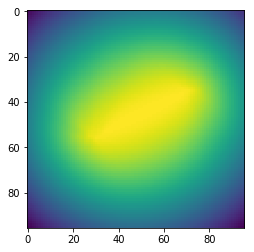

In [62]:
plt.imshow(sdf_others.reshape(96,96))

In [84]:
sdf_target = norm(sdfs[0]).reshape(-1)
sdf_others = (norm(sdfs[1])+norm(sdfs[2])).reshape(-1)
final = (1.2 * norm(sdfs[0]) - 0.1 * norm(sdfs[1]) - 0.1 * norm(sdfs[2])).reshape(-1)

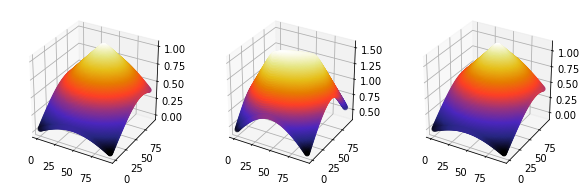

In [85]:
fig = plt.figure(figsize=(10, 3))
ax0 = fig.add_subplot(131, projection="3d")
ax1 = fig.add_subplot(132, projection="3d")
ax2 = fig.add_subplot(133, projection="3d")
ax0.scatter(x, y, sdf_target, c=sdf_target, cmap='CMRmap')
ax1.scatter(x, y, sdf_others, c=sdf_others, cmap='CMRmap')
ax2.scatter(x, y, final, c=final, cmap='CMRmap')

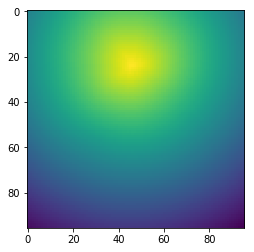

In [86]:
plt.imshow(final.reshape(96,96))

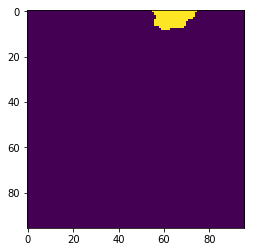

In [60]:
plt.imshow(masks[4])

In [ ]:
import pylab
NUM_COLORS = 5

cm = pylab.get_cmap('gist_rainbow')
for i in [0,2,4,1,3]:
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple
    print(color)
    #plt.imshow(np.ones([6,6,3])*color[:3])
    #plt.show()

# or if you really want a generator:
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

In [25]:
def norm(sdf):
    sdf_positive = sdf - sdf.min()
    return sdf_positive / sdf_positive.max()

In [ ]:
newsdf = norm(np.concatenate([s0, sg])+4*(np.concatenate([s0, sg])>0).astype(np.float))
empty = np.zeros([96,96,3])
for i in range(6):#len(newsdf)):
    empty += np.expand_dims(newsdf[i], 2) * np.array(cm(i/5)[:3])
plt.imshow(norm(empty))

In [20]:
sdf.init_tracker(state_img[0], masks)
m, success = sdf.get_tracker_masks(state_img[0], state_img[1], 3, 'HWC')

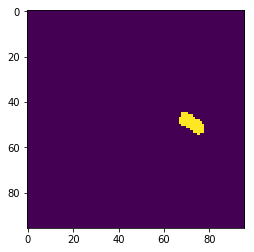

In [21]:
plt.imshow(m[2])

In [18]:
frame = state_img[0]
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = cv2.TrackerKCF_create()
    trackers.add(tracker, frame, bbox)

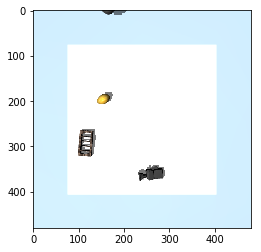

In [19]:
plt.imshow(state_img[0])

In [68]:
import random

In [100]:
[env.pos2pixel(*p) for p in info['poses']]

[(295, 388), (36, 378), (183, 147)]

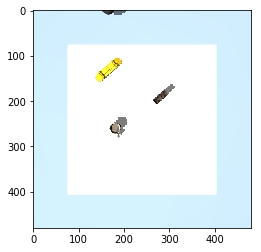

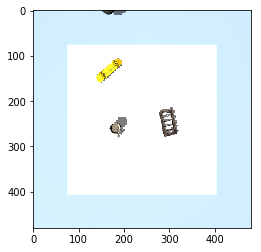

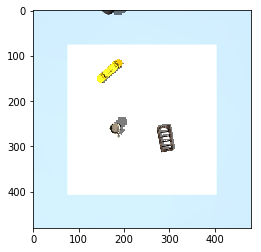

In [103]:
random.seed(0)
np.random.seed(11)
(state_img, goal_img), info = env.reset()
plt.imshow(state_img[0])
plt.show()

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]
for i in range(2):
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    
    (state_img, _), reward, done, info = env.step(action)
    plt.imshow(state_img[0])
    plt.show()

In [24]:
import random

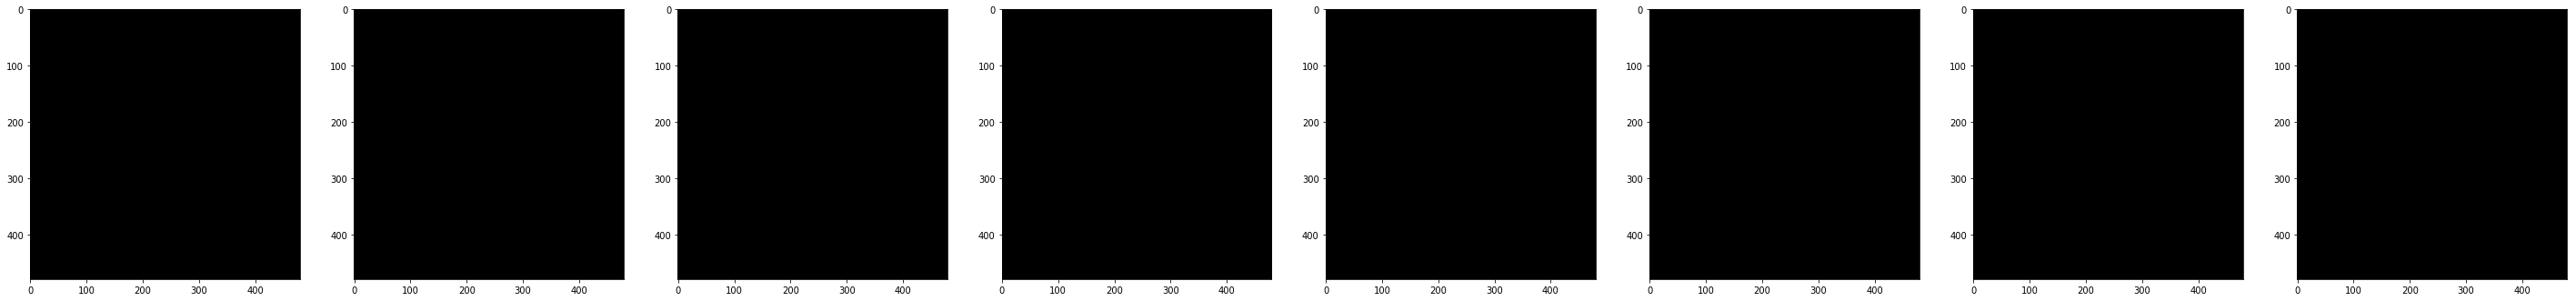

In [70]:
f, ax = plt.subplots(1, 8, figsize=(25, 5))
# f.set_figheight = 8
# f.set_figwidth = 40
for i in range(len(ax)):
    ax[i].imshow(np.zeros([480, 480, 3]))
f.savefig('test.png')
plt.show()

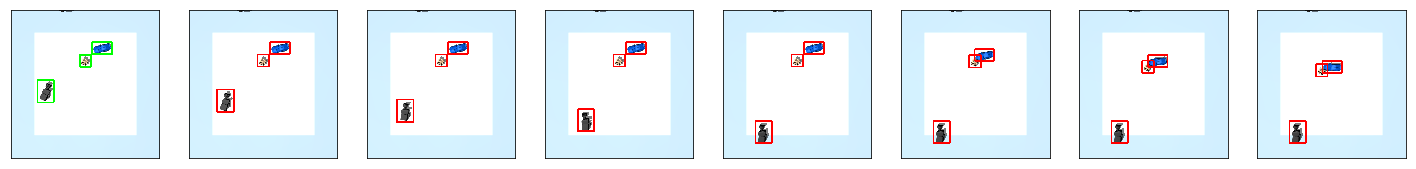

In [89]:
random.seed(0)
np.random.seed(13)

key = 'medianflow'
tracker_types = {
    'boost': cv2.TrackerBoosting_create,
    'mil': cv2.TrackerMIL_create,
    'kcf': cv2.TrackerKCF_create,
    'csrt': cv2.TrackerCSRT_create,
    'tld': cv2.TrackerTLD_create,
    'medianflow': cv2.TrackerMedianFlow_create,
    'goturn': cv2.TrackerGOTURN_create,
    'mosse': cv2.TrackerMOSSE_create
}

(state_img, goal_img), info = env.reset()
f, ax = plt.subplots(1, 8, figsize=(25, 5))

# initialize trackers
masks, feature = sdf.get_ucn_masks(state_img[0], None, 'HWC')
frame = (state_img[0] * 255).astype(np.uint8)
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = tracker_types[key]()
    trackers.add(tracker, frame, bbox)
    cv2.rectangle(frame, (sx, sy), (sx+dx, sy+dy), (0, 255, 0), 3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(frame)

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]

for i in range(7):
    st = time.time()
    # # random action
    # obj = np.random.randint(len(info['poses']))
    # py, px = env.pos2pixel(*info['poses'][obj])
    # theta = np.random.randint(8)
    # action = [px, py, theta]
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    #print(action)

    (state_img, _), reward, done, info = env.step(action)

    frame = (state_img[0] * 255).astype(np.uint8)
    (success, boxes) = trackers.update(frame)
    et = time.time()
    #print(success, et-st)
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
        # print(x, y, w, h)

    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].imshow(frame)
f.savefig('tracking_%s.png'%key)
plt.show()


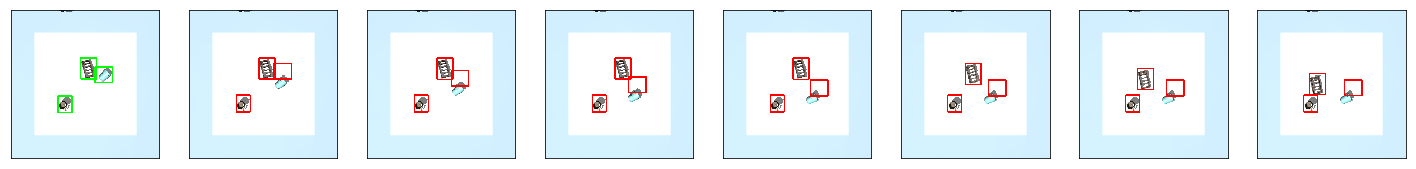

In [92]:
random.seed(0)
np.random.seed(16)

key = 'mil'
tracker_types = {
    'boost': cv2.TrackerBoosting_create,
    'mil': cv2.TrackerMIL_create,
    'kcf': cv2.TrackerKCF_create,
    'csrt': cv2.TrackerCSRT_create,
    'tld': cv2.TrackerTLD_create,
    'medianflow': cv2.TrackerMedianFlow_create,
    'goturn': cv2.TrackerGOTURN_create,
    'mosse': cv2.TrackerMOSSE_create
}

(state_img, goal_img), info = env.reset()
f, ax = plt.subplots(1, 8, figsize=(25, 5))

# initialize trackers
masks, feature = sdf.get_ucn_masks(state_img[0], None, 'HWC')
frame = (state_img[0] * 255).astype(np.uint8)
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = tracker_types[key]()
    trackers.add(tracker, frame, bbox)
    cv2.rectangle(frame, (sx, sy), (sx+dx, sy+dy), (0, 255, 0), 3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(frame)

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]

for i in range(7):
    st = time.time()
    # # random action
    # obj = np.random.randint(len(info['poses']))
    # py, px = env.pos2pixel(*info['poses'][obj])
    # theta = np.random.randint(8)
    # action = [px, py, theta]
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    #print(action)

    (state_img, _), reward, done, info = env.step(action)

    frame = (state_img[0] * 255).astype(np.uint8)
    (success, boxes) = trackers.update(frame)
    et = time.time()
    #print(success, et-st)
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
        # print(x, y, w, h)

    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].imshow(frame)
f.savefig('tracking_%s.png'%key)
plt.show()


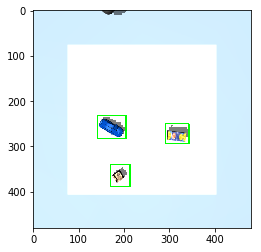

[259, 171, 0]
True 2.0291268825531006


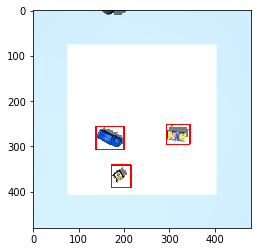

[283, 167, 0]
True 2.665876865386963


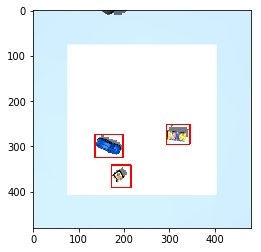

[301, 164, 0]
True 2.1610915660858154


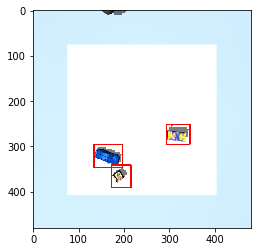

[324, 162, 0]
True 2.1700236797332764


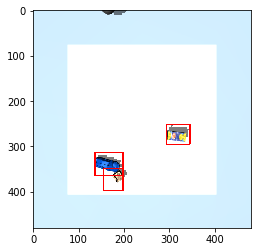

[278, 315, 1]
True 2.5637691020965576


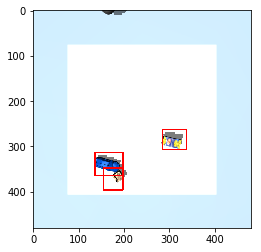

[291, 304, 1]
True 2.145122528076172


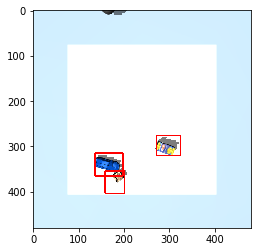

[305, 291, 1]
True 2.676703453063965


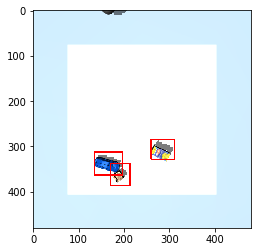

[316, 280, 1]
True 2.1588056087493896


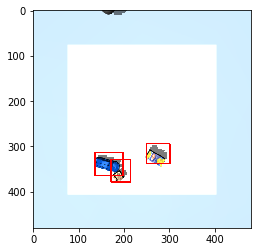

[326, 269, 1]
True 2.1637163162231445


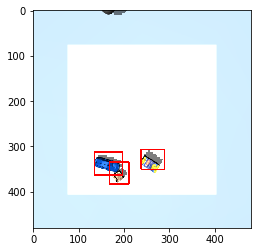

[339, 257, 1]
True 2.5470917224884033


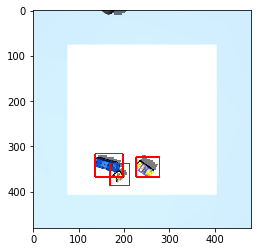

[351, 245, 2]
True 2.152430534362793


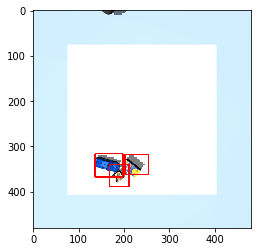

[348, 215, 2]
True 2.6121647357940674


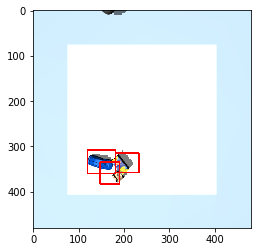

[341, 191, 2]
True 2.1408114433288574


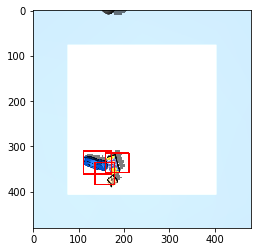

In [95]:
random.seed(0)
np.random.seed(2)

key = 'mil'
tracker_types = {
    'boost': cv2.TrackerBoosting_create,
    'mil': cv2.TrackerMIL_create,
    'kcf': cv2.TrackerKCF_create,
    'csrt': cv2.TrackerCSRT_create,
    'tld': cv2.TrackerTLD_create,
    'medianflow': cv2.TrackerMedianFlow_create,
    'goturn': cv2.TrackerGOTURN_create,
    'mosse': cv2.TrackerMOSSE_create
}

(state_img, goal_img), info = env.reset()

# initialize trackers
masks, feature = sdf.get_masks(state_img[0], None, 'HWC')
frame = (state_img[0] * 255).astype(np.uint8)
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = tracker_types[key]()
    trackers.add(tracker, frame, bbox)
    cv2.rectangle(frame, (sx, sy), (sx+dx, sy+dy), (0, 255, 0), 2)
plt.imshow(frame)
plt.show()

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]
for i in range(13):
    st = time.time()
    
    # # random action
    # obj = np.random.randint(len(info['poses']))
    # py, px = env.pos2pixel(*info['poses'][obj])
    # theta = np.random.randint(8)
    # action = [px, py, theta]
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    print(action)

    (state_img, _), reward, done, info = env.step(action)

    frame = (state_img[0] * 255).astype(np.uint8)
    (success, boxes) = trackers.update(frame)
    et = time.time()
    print(success, et-st)
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # print(x, y, w, h)

    plt.imshow(frame)
    plt.show()
    # print()

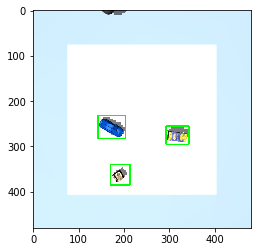

[259, 171, 0]
True 2.4834141731262207


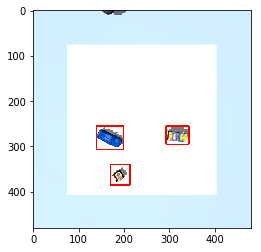

[283, 167, 0]
True 2.1458234786987305


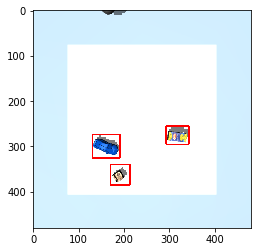

[302, 158, 0]
True 2.143033742904663


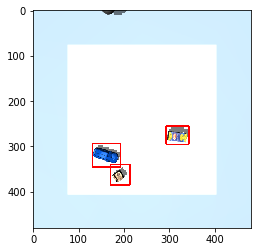

[321, 158, 0]
True 2.5310988426208496


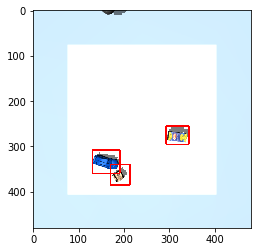

[279, 317, 1]
True 2.1439096927642822


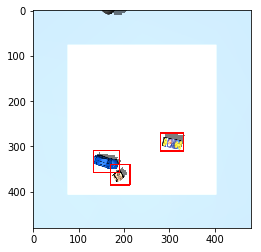

[293, 306, 1]
True 2.1415038108825684


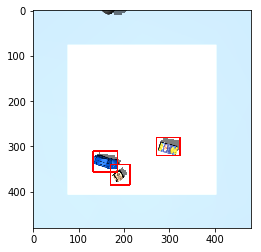

[305, 297, 1]
True 2.52964448928833


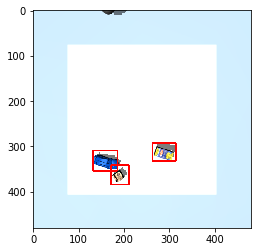

[316, 288, 1]
True 2.158217668533325


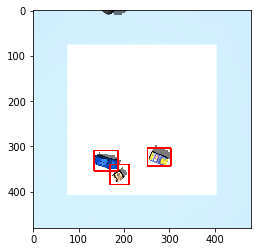

[328, 276, 1]
True 2.1602606773376465


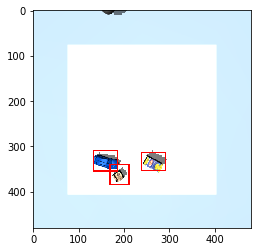

[339, 264, 1]
True 2.5119049549102783


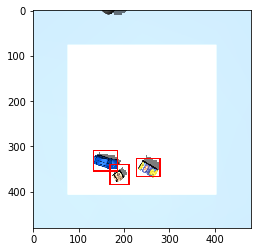

[351, 253, 2]
True 2.1446986198425293


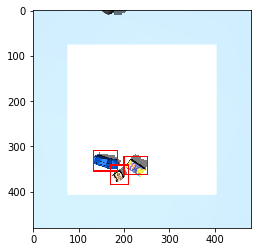

[347, 225, 2]
True 2.1552367210388184


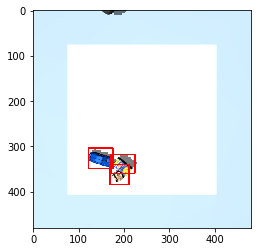

[345, 196, 2]
True 2.5255258083343506


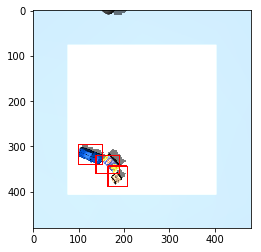

In [96]:
random.seed(0)
np.random.seed(2)

key = 'csrt'
tracker_types = {
    'boost': cv2.TrackerBoosting_create,
    'mil': cv2.TrackerMIL_create,
    'kcf': cv2.TrackerKCF_create,
    'csrt': cv2.TrackerCSRT_create,
    'tld': cv2.TrackerTLD_create,
    'medianflow': cv2.TrackerMedianFlow_create,
    'goturn': cv2.TrackerGOTURN_create,
    'mosse': cv2.TrackerMOSSE_create
}

(state_img, goal_img), info = env.reset()

# initialize trackers
masks, feature = sdf.get_masks(state_img[0], None, 'HWC')
frame = (state_img[0] * 255).astype(np.uint8)
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = tracker_types[key]()
    trackers.add(tracker, frame, bbox)
    cv2.rectangle(frame, (sx, sy), (sx+dx, sy+dy), (0, 255, 0), 2)
plt.imshow(frame)
plt.show()

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]
for i in range(13):
    st = time.time()
    
    # # random action
    # obj = np.random.randint(len(info['poses']))
    # py, px = env.pos2pixel(*info['poses'][obj])
    # theta = np.random.randint(8)
    # action = [px, py, theta]
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    print(action)

    (state_img, _), reward, done, info = env.step(action)

    frame = (state_img[0] * 255).astype(np.uint8)
    (success, boxes) = trackers.update(frame)
    et = time.time()
    print(success, et-st)
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # print(x, y, w, h)

    plt.imshow(frame)
    plt.show()
    # print()

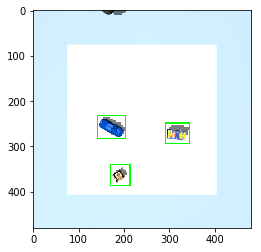

[259, 171, 0]
True 1.9560353755950928


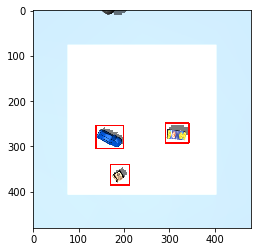

[283, 167, 0]
True 2.63076114654541


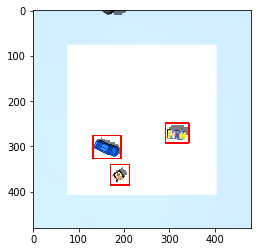

[305, 160, 0]
True 2.037020444869995


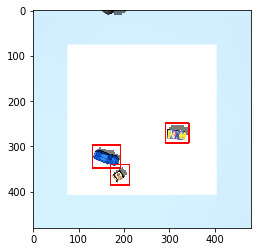

[327, 159, 0]
True 2.161618947982788


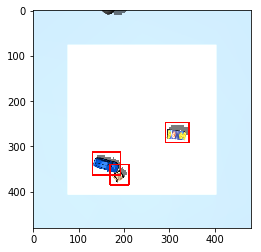

[275, 315, 1]
True 2.620810031890869


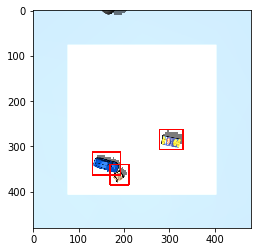

[290, 303, 1]
True 2.0190577507019043


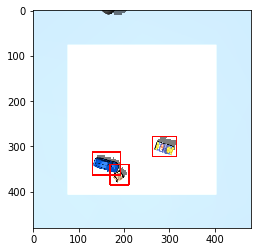

[304, 289, 1]
True 2.166269302368164


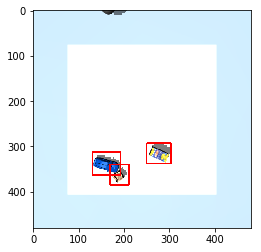

[318, 277, 1]
True 2.155087947845459


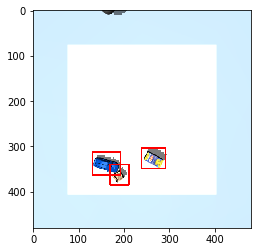

[329, 265, 1]
True 2.5027096271514893


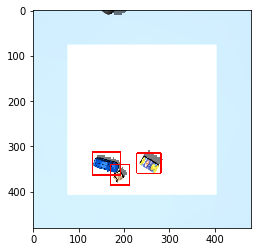

[340, 256, 1]
True 2.128922939300537


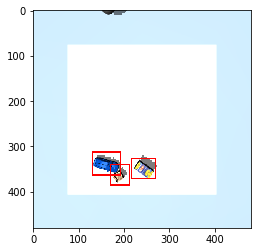

[351, 244, 2]
True 2.107814073562622


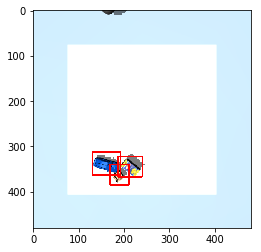

[347, 214, 2]
True 2.505230665206909


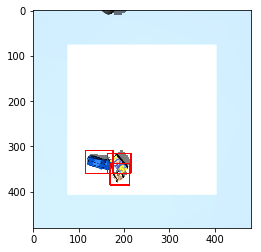

[339, 189, 2]
True 2.1312923431396484


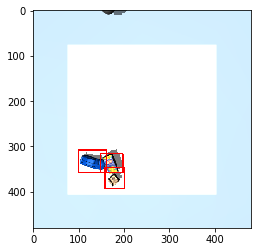

In [97]:
random.seed(0)
np.random.seed(2)

key = 'medianflow'
tracker_types = {
    'boost': cv2.TrackerBoosting_create,
    'mil': cv2.TrackerMIL_create,
    'kcf': cv2.TrackerKCF_create,
    'csrt': cv2.TrackerCSRT_create,
    'tld': cv2.TrackerTLD_create,
    'medianflow': cv2.TrackerMedianFlow_create,
    'goturn': cv2.TrackerGOTURN_create,
    'mosse': cv2.TrackerMOSSE_create
}

(state_img, goal_img), info = env.reset()

# initialize trackers
masks, feature = sdf.get_masks(state_img[0], None, 'HWC')
frame = (state_img[0] * 255).astype(np.uint8)
trackers = cv2.MultiTracker_create()
for m in masks:
    sy, sx = np.array(np.where(m)).min(1)
    my, mx = np.array(np.where(m)).max(1)
    dy = my - sy
    dx = mx - sx
    bbox = (sx, sy, dx, dy)
    
    tracker = tracker_types[key]()
    trackers.add(tracker, frame, bbox)
    cv2.rectangle(frame, (sx, sy), (sx+dx, sy+dy), (0, 255, 0), 2)
plt.imshow(frame)
plt.show()

actions = [(0, 0) for j in range(4)] \
        + [(1, 1) for k in range(6)] \
        + [(1, 2) for k in range(3)]
for i in range(13):
    st = time.time()
    
    # # random action
    # obj = np.random.randint(len(info['poses']))
    # py, px = env.pos2pixel(*info['poses'][obj])
    # theta = np.random.randint(8)
    # action = [px, py, theta]
    obj = actions[i][0]
    py, px = env.pos2pixel(*info['poses'][obj])
    theta = actions[i][1]
    action = [px, py, theta]
    print(action)

    (state_img, _), reward, done, info = env.step(action)

    frame = (state_img[0] * 255).astype(np.uint8)
    (success, boxes) = trackers.update(frame)
    et = time.time()
    print(success, et-st)
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # print(x, y, w, h)

    plt.imshow(frame)
    plt.show()
    # print()

In [5]:
nb_st

tensor([[1],
        [3],
        [0],
        [3],
        [3],
        [0],
        [1]], device='cuda:0')

In [6]:
nb_g

tensor([[1],
        [3],
        [0],
        [2],
        [0],
        [2],
        [2]], device='cuda:0')

In [10]:
atn_in[3]

tensor([[0.0000, 0.4931, 0.5069, 0.0000, 0.0000, 0.0000],
        [0.5196, 0.0000, 0.4804, 0.0000, 0.0000, 0.0000],
        [0.5264, 0.4736, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [13]:
atn_g[3]

tensor([[0.0000, 0.0000, 0.0000, 0.4086, 0.5914, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4086, 0.5914, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4815, 0.5185, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [12]:
torch.matmul(atn_g[0], torch.ones(2*nb, f).to(device)).shape

torch.Size([6, 12])

In [12]:
adj_inscene, adj_goal = qnet.generate_adj(nb_st, nb_g)

In [16]:
x = torch.zeros([3,2,10])

In [17]:
x.shape

torch.Size([3, 2, 10])

In [21]:
x.reshape(3, 1, *x.shape[-2:]).shape

torch.Size([3, 1, 2, 10])

In [ ]:
import torchvision.models as models

In [ ]:
resnet50 = models.resnet50(pretrained=True).cuda()

In [ ]:
f = resnet50(torch.tensor(state[0].transpose([2,0,1])).view([1, 3, 480, 480]).type(torch.cuda.FloatTensor))

In [ ]:
f.shape

In [ ]:
f.cpu().detach().numpy().shape

In [ ]:
(1, *f.shape)

In [ ]:
y.shape

In [ ]:
q = np.random.random([480,480])

In [ ]:
y[:, q>0.5] = 0

In [ ]:
plt.imshow(y.cpu().permute([1,2,0]))

In [ ]:
torch.cat([y, y]).shape

In [ ]:
y = copy.deepcopy(x[0])

In [ ]:
y[y<0.9]=0

In [ ]:
plt.imshow(y.cpu().permute([1,2,0]))

In [1]:
import sys
sys.path.append('../../ur5_mujoco')

#from ur5_env import *
from realobjects_env import *
from object_env import *

from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

from sdf_module import *

In [10]:
sdf = SDFModule(rgb_feature=True, convex_hull=False, binary_hole=True, using_depth=True)
sdf2 = SDFModule(rgb_feature=True, convex_hull=False, binary_hole=True, using_depth=False)

In [4]:
env = UR5Env(render=True, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', camera_depth=True)
env = objectwise_env(env, num_blocks=3, mov_dist=0.08, detection=True)

Creating window glfw


In [5]:
(st, g), info = env.reset()

In [7]:
st[0].shape

(480, 480, 3)

In [8]:
st[1].shape

(480, 480)

In [8]:
m, f = sdf.get_masks(st[0], 3*st[1]-2, 'HWC')
len(m)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [11]:
m, f = sdf2.get_masks(st[0], 3*st[1]-2, 'HWC')
len(m)

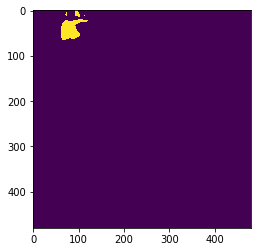

In [58]:
plt.imshow(m[7])

In [4]:
from PIL import Image

In [61]:
fpath = '/home/gun/Desktop/UnseenObjectClustering/data/tabletop'
dpath = os.path.join(fpath, 'depth_00002.png')
rpath = os.path.join(fpath, 'rgb_00002.jpeg')
depth = Image.open(dpath)
rgb = Image.open(rpath)

In [62]:
depth = np.array(depth)
rgb = np.array(rgb)

In [63]:
sdf.params['img_width'] = 640

In [64]:
xyz2 = sdf.process_depth(depth)

In [65]:
xyz2[0]

array([[-1875.00672568, -1406.25504426,  3395.        ],
       [-1868.5967708 , -1405.84083069,  3394.        ],
       [-1862.73910067, -1405.84083069,  3394.        ],
       ...,
       [  895.06718337,  -677.65338804,  1636.        ],
       [  897.89073916,  -677.65338804,  1636.        ],
       [  900.71429494,  -677.65338804,  1636.        ]])

In [77]:
(depth/1000).max()

3.395

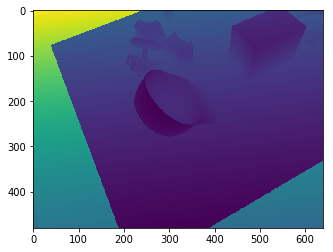

In [78]:
plt.imshow(depth/1000)

In [66]:
m, f = sdf.get_masks(rgb/255, depth/1000, 'HWC')

In [67]:
len(m)

10

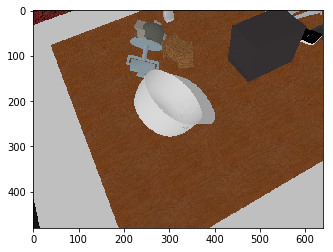

In [68]:
plt.imshow(rgb)

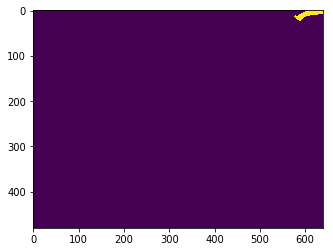

In [69]:
plt.imshow(m[0])

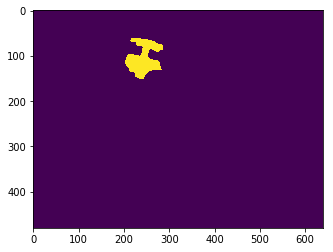

In [70]:
plt.imshow(m[1])

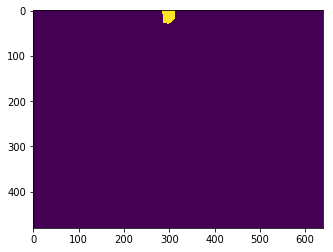

In [71]:
plt.imshow(m[2])

In [2]:
sdf = SDFModule() #rgb_feature=True, ucn_feature=False, resnet_feature=True)

/home/gun/Desktop/ur5_manipulation/object_wise/dqn/../../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [3]:
from PIL import Image

In [4]:
im1 = Image.open('test_scenes/detection/7.png')
im2 = Image.open('test_scenes/detection/8.png')

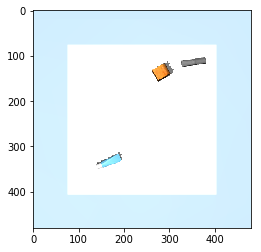

In [5]:
plt.imshow(np.array(im1)[:, :480])

In [6]:
s1 = np.array(im1)[:, :480] / 255.
s2 = np.array(im2)[:, :480] / 255.

sdf1, sdf_raw1, feature1 = sdf.get_sdf_features(s1, None, 3)
sdf2, sdf_raw2, feature2 = sdf.get_sdf_features(s2, None, 3)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [7]:
for i in range(3):
    plt.imsave('test_scenes/sr1_%d.png'%i, np.clip(sdf_raw1[i], -0.1, 0.04), cmap='seismic', vmin=-0.15, vmax=0.07)
    plt.imsave('test_scenes/sr2_%d.png'%i, np.clip(sdf_raw2[i], -0.1, 0.04), cmap='seismic', vmin=-0.15, vmax=0.07)

In [11]:
x = s1.transpose([2, 0, 1])
x_tensor = torch.Tensor(x).unsqueeze(0).to('cuda')
x_test = torch.Tensor(x).to('cuda')

In [12]:
x_tensor.shape

torch.Size([1, 3, 480, 480])

In [14]:
sdf.network(x_tensor, None, None).shape

torch.Size([1, 64, 480, 480])

In [16]:
sdf.network(x_test, None, None).shape

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 480, 480] instead

In [ ]:
plt.imshow(sdf1[0])

In [ ]:
plt.imshow(np.abs(sdf1[0])<0.005)

In [ ]:
sdf1[0].max()

In [ ]:
plt.imshow(sdf1[0], cmap='seismic', vmin=-0.5, vmax=0.5)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.05, 0.04), cmap='seismic', vmin=-0.1, vmax=0.1)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.1, 0.04), cmap='seismic', vmin=-0.15, vmax=0.07)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.12, 0.04), cmap='seismic', vmin=-0.2, vmax=0.12)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.1, 0.04), cmap='seismic', vmin=-0.2, vmax=0.1)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.05, 0.04), cmap='coolwarm', vmin=-0.08, vmax=0.05)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.05, 0.04), cmap='spectral', vmin=-0.1, vmax=0.1)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.05, 0.04), cmap='jet', vmin=-0.1, vmax=0.1)

In [ ]:
plt.imshow(np.clip(sdf1[0], -0.05, 0.04), cmap='rainbow', vmin=-0.1, vmax=0.1)

In [4]:
env = UR5Env(render=True, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', xml_ver=0)
env = objectwise_env(env, num_blocks=3, mov_dist=0.08, detection=True)

Creating window glfw


In [12]:
env.env.sim.model.camera_name2id('rlview')

1

In [13]:
env.env.sim.model.cam_fovy[1]

45.0

In [ ]:
state = env.reset()

In [ ]:
state[0].shape

In [ ]:
state[1].shape

In [ ]:
st = time.time()
s0, s0_raw, f0 = sdf.get_sdf_features(state[0], rotate=True)
sg, sg_raw, fg = sdf.get_sdf_features(state[1], rotate=True)
et = time.time()
print(et-st)

In [ ]:
s0[0].max()

In [ ]:
plt.imshow(np.abs(s0[0])<0.005)

In [ ]:
x = np.abs(s0[0])<0.01

In [ ]:
plt.imshow(x)

In [ ]:
from skimage.morphology import convex_hull_image

In [ ]:
plt.imshow(convex_hull_image(x))

In [ ]:
from scipy.spatial import ConvexHull

In [ ]:
py, px = np.where(x) 
p = np.array(list(zip(px,py)))

In [ ]:
hull = ConvexHull(p)

In [ ]:
hull.simplices

In [ ]:
hull.vertices

In [ ]:
plt.fill(p[hull.vertices, 0], p[hull.vertices,1], 'k', alpha=0.3)

In [ ]:
from scipy.ndimage import morphology

In [ ]:
from scipy.ndimage import morphology as morphology

In [ ]:
plt.imshow(morphology.binary_fill_holes(x))

In [ ]:
c, h = cv2.findContours(x, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

In [ ]:
px, py = np.where(x) 
p = np.array(list(zip(px,py)))

In [ ]:
hull = cv2.convexHull(p)

In [ ]:
dst = np.zeros_like(x)
plt.imshow(cv2.drawContours(dst, [hull], 0, [1], 2))

In [ ]:
#dst = np.zeros_like(x)
dst = np.zeros([96,96,3])
for i in c:
    hull = cv2.convexHull(i, clockwise=True)
    cv2.drawContours(dst, [hull], 0, (0, 0, 255), 2)

In [ ]:
hull

In [ ]:
plt.imshow(dst)

In [ ]:
plt.imshow(((np.abs(s0[0])<0.01) * np.ones([3,1,1])).transpose([1,2,0]))

In [ ]:
np.concatenate(f0, 1).shape

In [ ]:
np.concatenate(f0, 1).shape

In [ ]:
np.concatenate(f0[0], 1).shape

In [ ]:
import pylab
NUM_COLORS = 5

cm = pylab.get_cmap('gist_rainbow')
for i in [0,2,4,1,3]:
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple
    print(color)
    #plt.imshow(np.ones([6,6,3])*color[:3])
    #plt.show()

# or if you really want a generator:
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

In [ ]:
st = time.time()
s0, s0_raw, (r0, f0) = sdf.get_sdf_features(state[0], rotate=True)
sg, sg_raw, (rg, fg) = sdf.get_sdf_features(state[1], rotate=True)
et = time.time()
print(et-st)

In [ ]:
def norm(sdf):
    sdf_positive = sdf - sdf.min()
    return sdf_positive / sdf_positive.max()

In [ ]:
plt.imshow(norm(sg[0]))

In [ ]:
plt.imshow(norm(sg.transpose([1,2,0])))

In [ ]:
ss = sg.copy()
ss[sg<0] = 0
plt.imshow(norm(ss.transpose([1,2,0])))

In [ ]:
plt.imshow((sg.transpose([1,2,0])>0).astype(np.float))

In [ ]:
plt.imshow(norm(sg.transpose([1,2,0]))+(sg.transpose([1,2,0])>0).astype(np.float))

In [ ]:
plt.imshow(norm(sg.transpose([1,2,0])+2*(sg.transpose([1,2,0])>0).astype(np.float)))

In [ ]:
cm(0)[:3]

In [ ]:
newsdf = norm(sg+2*(sg>0).astype(np.float))

In [ ]:
newsdf = norm(np.concatenate([s0, sg])+4*(np.concatenate([s0, sg])>0).astype(np.float))
empty = np.zeros([96,96,3])
for i in range(6):#len(newsdf)):
    empty += np.expand_dims(newsdf[i], 2) * np.array(cm(i/5)[:3])
plt.imshow(norm(empty))

In [ ]:
plt.imshow(np.expand_dims(newsdf[0], 2) * np.array(cm(0)[:3]))

In [ ]:
plt.imshow(np.clip(s0_raw[0], -100, 100))

In [ ]:
plt.imshow(s0_raw[0])

In [ ]:
plt.imshow(s0_raw.transpose([1,2,0]))

In [ ]:
linear_sum_assignment(distance_matrix(rg, r0)) 

In [ ]:
linear_sum_assignment(distance_matrix(fg, f0)) 

In [ ]:
st = time.time()
s0, s0_raw, (r0, f0) = sdf.get_sdf_features(state[0])
sg, sg_raw, (rg, fg) = sdf.get_sdf_features(state[1])
et = time.time()
print(et-st)

In [ ]:
linear_sum_assignment(distance_matrix(rg, r0)) 

In [ ]:
linear_sum_assignment(distance_matrix(fg, f0)) 

In [ ]:
mt, ft = sdf.get_masks(state[0], data_format='HWC', rotate=True)
mg, fg = sdf.get_masks(state[1], data_format='HWC', rotate=True)


In [ ]:
plt.figure(figsize=(8, 30))
N = 10
ax1 = plt.subplot(N, 2, 1)
ax2 = plt.subplot(N, 2, 2)
ax1.imshow(state[0])
ax2.imshow(state[1])
for i in range(1, N):
    _ax1 = plt.subplot(N, 2, 2*i+1)
    _ax2 = plt.subplot(N, 2, 2*i+2)
    _ax1.imshow(ft[i-1])
    _ax2.imshow(fg[i-1])

In [ ]:
sdf.object_matching((r0, f0), (rg, fg))

In [ ]:
s_align = s0[sdf.object_matching((r0, f0), (rg, fg))]

In [ ]:
np.round

In [ ]:
px, py = np.where(s_align[0]>0)
px = px.mean().round()
py = py.mean().round()
print(px, py)

In [ ]:
gx, gy = np.where(sg[0]>0)
gx = gx.mean().round()
gy = gy.mean().round()
print(gx, gy)

In [ ]:
from PIL import Image, ImageDraw

In [ ]:
state[0].shape

In [ ]:
plt.imshow(np.concatenate([state[0], state[1]], 1))

In [ ]:
im = Image.fromarray((np.concatenate([state[0], state[1]], 1)*255).astype(np.uint8))
draw = ImageDraw.Draw(im)
for i in range(3):
    px, py = np.where(s_align[i]>0)
    px = px.mean().round()
    py = py.mean().round()
    gx, gy = np.where(sg[i]>0)
    gx = gx.mean().round()
    gy = gy.mean().round()
    draw.line((5*py, 5*px, 5*gy+480, 5*gx), fill=128, width=3)
im.show()

In [ ]:
plt.imshow(s_align[0]>0)

In [ ]:
st = time.time()
_ = sdf.get_masks(state[0])
_ = sdf.get_masks(state[1])
et = time.time()
print(et-st)

In [ ]:
st = time.time()
image = state[0]
# image = image.transpose([2, 0, 1])

im_tensor = torch.from_numpy(image).type(torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()
features = sdf.network(im_tensor, None).detach()
out_label, selected_pixels = clustering_features(features, num_seeds=100)

et = time.time()
print(et-st)

In [ ]:
features.shape

In [ ]:
torch.cat((features, features)).shape

In [ ]:
out_labem, sp = clustering_features(torch.cat((features, features)), num_seeds=100)

In [ ]:
out_labem.shape

In [ ]:
out_labem

In [ ]:
plt.imshow(out_labem[0])

In [ ]:
plt.imshow(out_labem[1])

In [ ]:
im_tensor.shape

In [ ]:
plt.imshow(state[0])

In [ ]:
plt.imshow(s0.transpose([1,2,0]))

In [ ]:
plt.imshow(state[1])

In [ ]:
plt.imshow(sg[:3].transpose([1,2,0]))

In [ ]:
np.array(f0).dot(np.array(fg).T)

In [ ]:
distance_matrix(f0, fg)

In [ ]:
xn = f0 / np.linalg.norm(f0, axis=1).reshape(3, 1)
yn = fg / np.linalg.norm(fg, axis=1).reshape(3, 1)

In [ ]:
xn.dot(yn.T)

In [ ]:
xn.dot(yn.T).argmax(1)

In [ ]:
distance_matrix(xn, yn)

In [ ]:
row_ind, col_ind = linear_sum_assignment(distance_matrix(xn, yn))
col_ind

In [ ]:
r0n = r0 / np.linalg.norm(r0, axis=1).reshape(3, 1)
rgn = rg / np.linalg.norm(rg, axis=1).reshape(3, 1)

In [ ]:
r0n.dot(rgn.T)

In [ ]:
r0n.dot(rgn.T).argmax(1)

In [ ]:
distance_matrix(r0, rg)

In [ ]:
distance_matrix(r0n, rgn)

In [ ]:
row_ind, col_ind = linear_sum_assignment(distance_matrix(r0, rg))
print(col_ind)

In [ ]:
new0 = np.concatenate([r0, f0], axis=1)
newg = np.concatenate([rg, fg], axis=1)

In [ ]:
new0n = new0 / np.linalg.norm(new0, axis=1).reshape(3, 1)
newgn = newg / np.linalg.norm(newg, axis=1).reshape(3, 1)

In [ ]:
new0n.dot(newgn.T)

In [ ]:
new0n.dot(newgn.T).argmax(1)

In [ ]:
idx = new0n.dot(newgn.T).argmax(1)
new0n.dot(newgn[idx].T).argmax(1)

In [ ]:
ss, sg = sdf.get_aligned_sdfs(state[0], state[1])

In [ ]:
plt.imshow(ss.transpose([1,2,0]))

In [ ]:
plt.imshow(sg.transpose([1,2,0]))

In [ ]:
import cv2

In [ ]:
plt.imshow(state[0][:,:,0])

In [ ]:
x = cv2.resize(state[0][:,:,0], (96, 96))
plt.imshow(x)

In [ ]:
x.shape

In [ ]:
x = cv2.resize(s0[0], (96, 96))
plt.imshow(x)

In [ ]:
s0.shape

In [ ]:
plt.imshow(s0[1]>0)

In [ ]:
[px], [py] = np.where(s0[1]==s0[1].max())

In [ ]:
px, py

In [ ]:
z = np.zeros([96, 96])
z[px, py] = 1
plt.imshow(z)

In [ ]:
import numpy as np

In [ ]:
x = np.random.random([4, 5])
y = np.random.random([3, 5])

In [ ]:
x

In [ ]:
y

In [ ]:
x.dot(y.T)

In [ ]:
x.dot(y.T).argmax(1)

In [ ]:
x.dot(y.T).argmax(0)

In [ ]:
x[x.dot(y.T).argmax(0)]

In [ ]:
xn = x / np.linalg.norm(x, axis=1).reshape(4, 1)
yn = y / np.linalg.norm(y, axis=1).reshape(3, 1)

In [ ]:
xn.dot(yn.T)

In [ ]:
xn.dot(yn.T).argmax(1)